# Data Cleaning
This Data cleaning process has been done by thoroughly analyzing the 3 EDA Notebooks and finding patterns or important insights that hint into the necessity of data cleaning.

# Step 0 – Load the Dataset and Inspect Initial Structure

We start by loading the Kaggle Cardiovascular Disease dataset and doing an initial inspection.  
This gives us a baseline to compare all future transformations.  

From our earlier EDA PDFs, we already know:
- The dataset has ~70k rows and 13 columns.
- No missing values initially.
- Data types look consistent but contain clear *outliers* and *encoding issues*.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load raw
df_raw = pd.read_csv("../data/raw/cardio_train.csv", sep=';')

# Working copy
df = df_raw.copy()

print(df_raw.shape)
df_raw.head()

(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Step 1 – Remove the ID column and Convert Age from Days to Years

The `id` column is a unique identifier and brings no predictive value — it could even introduce data leakage in models.  
The `age` column is given in **days**, which is not interpretable for medical or statistical analysis.  
We convert it to integer **years**, improving interpretability and comparability with clinical standards.

We will visualize the age distribution before and after conversion to confirm that the transformation preserves shape.


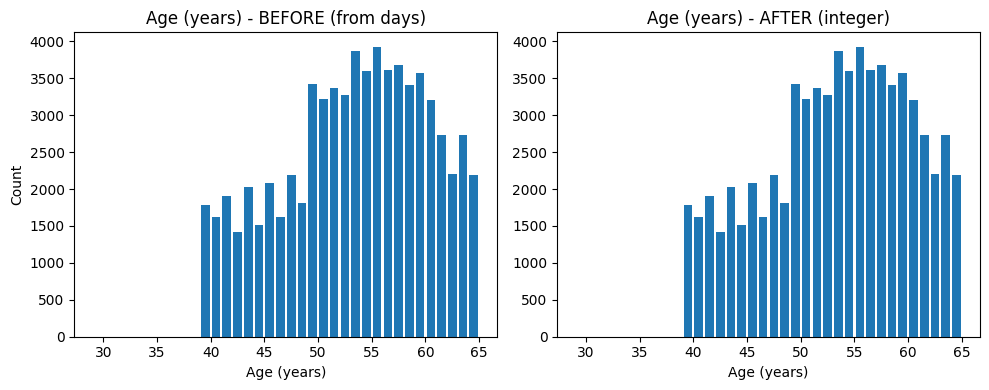

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Keep a copy before transformation
df_step0 = df.copy()

# Convert
if 'id' in df.columns:
    df = df.drop(columns=['id'])
df['age_years'] = (df['age'] / 365).astype(int)
df = df.drop(columns=['age'])

# Use integer bins for consistent visualization
bins = np.arange(29, 66, 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# BEFORE (but plotted with integer bin edges)
axes[0].hist(df_step0['age'] / 365, bins=bins, rwidth=0.8)
axes[0].set_title("Age (years) - BEFORE (from days)")
axes[0].set_xlabel("Age (years)")
axes[0].set_ylabel("Count")

# AFTER (integer)
axes[1].hist(df['age_years'], bins=bins, rwidth=0.8)
axes[1].set_title("Age (years) - AFTER (integer)")
axes[1].set_xlabel("Age (years)")

plt.tight_layout()
plt.show()


# Step 2 – Clean Height, Weight, and Calculate BMI

From our EDA, we noticed biologically impossible values:
- Heights as low as 55 cm and above 250 cm
- Weights under 30 kg or above 200 kg  

Such entries distort statistics and model relationships.

We compute the **Body Mass Index (BMI)** and then remove rows violating realistic adult thresholds:
- `140 ≤ height ≤ 210`
- `30 ≤ weight ≤ 200`
- `15 ≤ BMI ≤ 60`

These limits capture the full adult physiological range while discarding clearly corrupted entries.

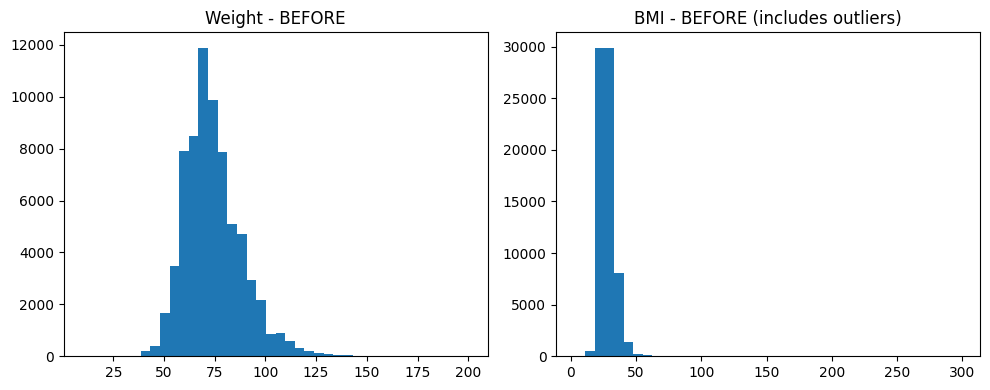

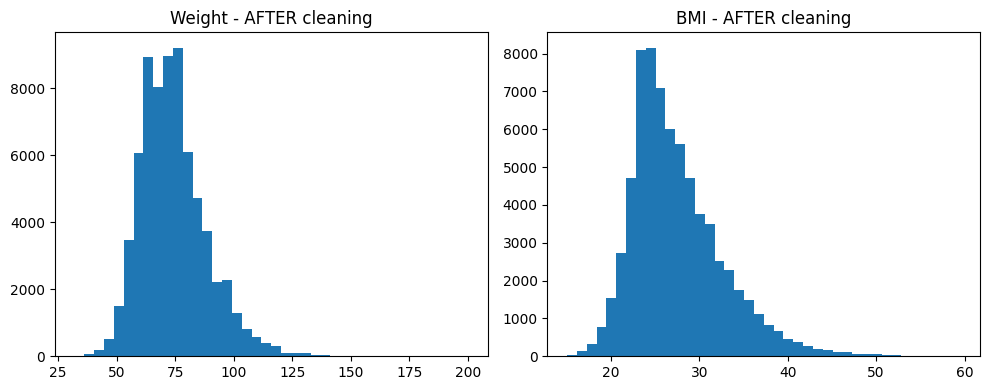

Rows removed in Step 2: 199


In [3]:
df_step1 = df.copy()

# Compute BMI
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2

# Visualize before cleaning
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df_step1['weight'], bins=40)
axes[0].set_title("Weight - BEFORE")
axes[1].hist(df['BMI'], bins=40)
axes[1].set_title("BMI - BEFORE (includes outliers)")
plt.tight_layout()
plt.show()

# Apply filters
mask = (
    df['height'].between(140, 210) &
    df['weight'].between(30, 200) &
    df['BMI'].between(15, 60)
)
df = df[mask].copy()

# Visualize after cleaning
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df['weight'], bins=40)
axes[0].set_title("Weight - AFTER cleaning")
axes[1].hist(df['BMI'], bins=40)
axes[1].set_title("BMI - AFTER cleaning")
plt.tight_layout()
plt.show()

print("Rows removed in Step 2:", df_step1.shape[0] - df.shape[0])


# Step 3 – Clean and Validate Blood Pressure Data

Blood pressure values (`ap_hi`, `ap_lo`) contained clear errors in our EDA:
- Negative and extreme values  
- Cases where `ap_lo > ap_hi`, likely swapped entries  

We fix these by:
1. Keeping only realistic ranges  
   (`80 ≤ ap_hi ≤ 250`, `40 ≤ ap_lo ≤ 200`)
2. Swapping values when `ap_lo > ap_hi`
3. Adding **pulse pressure (`pp`)** = `ap_hi - ap_lo`

Pulse pressure helps us **check validity** (it should stay within 10–150 mmHg)  
and is also **clinically relevant**, as higher PP often signals greater cardiovascular risk.

After cleaning, we verify the distributions of systolic and diastolic pressures to ensure they look realistic.


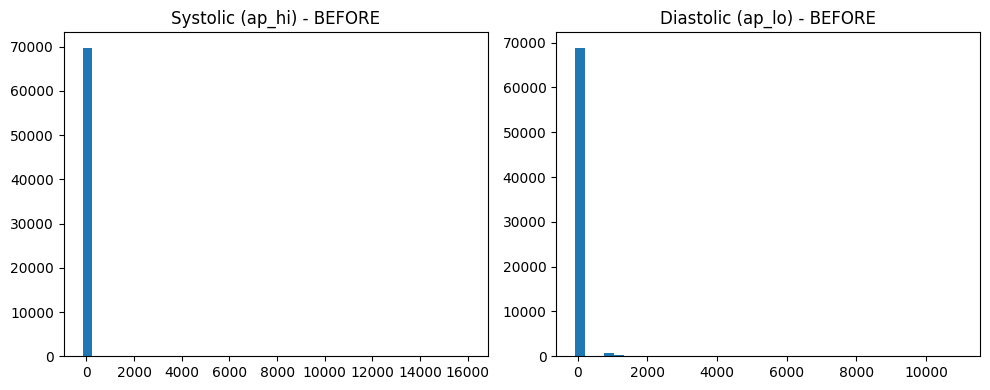

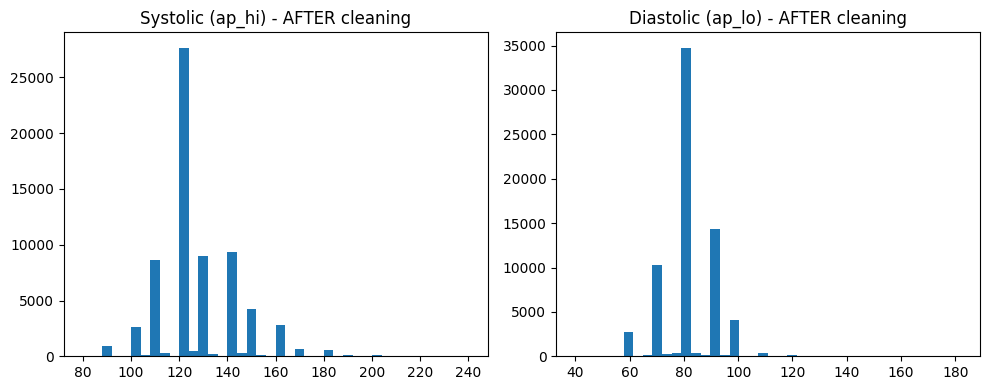

Rows removed in Step 3: 1239


In [4]:
df_step2 = df.copy()

# Before cleaning distributions
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df_step2['ap_hi'], bins=40)
axes[0].set_title("Systolic (ap_hi) - BEFORE")
axes[1].hist(df_step2['ap_lo'], bins=40)
axes[1].set_title("Diastolic (ap_lo) - BEFORE")
plt.tight_layout()
plt.show()

# Cleaning logic
df = df[df['ap_hi'].between(80, 250)]
df = df[df['ap_lo'].between(40, 200)]

swapped = df['ap_lo'] > df['ap_hi']
df.loc[swapped, ['ap_hi', 'ap_lo']] = df.loc[swapped, ['ap_lo', 'ap_hi']].to_numpy()

df['pp'] = df['ap_hi'] - df['ap_lo']
df = df[(df['ap_lo'] < df['ap_hi']) & (df['pp'].between(10, 150))]

# After cleaning distributions
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df['ap_hi'], bins=40)
axes[0].set_title("Systolic (ap_hi) - AFTER cleaning")
axes[1].hist(df['ap_lo'], bins=40)
axes[1].set_title("Diastolic (ap_lo) - AFTER cleaning")
plt.tight_layout()
plt.show()

print("Rows removed in Step 3:", df_step2.shape[0] - df.shape[0])


# Step 4 – Validate and Restrict Categorical Values

Several columns must strictly adhere to limited categorical sets.
This step ensures internal consistency and prevents model confusion caused by unexpected labels.

Expected domains:
- `gender ∈ {1, 2}`
- `cholesterol ∈ {1, 2, 3}`
- `gluc ∈ {1, 2, 3}`
- `smoke, alco, active, cardio ∈ {0, 1}`

We verify these, remove invalid entries if found, and visualize one example to confirm.

Invalid values before filtering:
gender: 0
cholesterol: 0
gluc: 0
smoke: 0
alco: 0
active: 0
cardio: 0
Rows removed in Step 4: 0


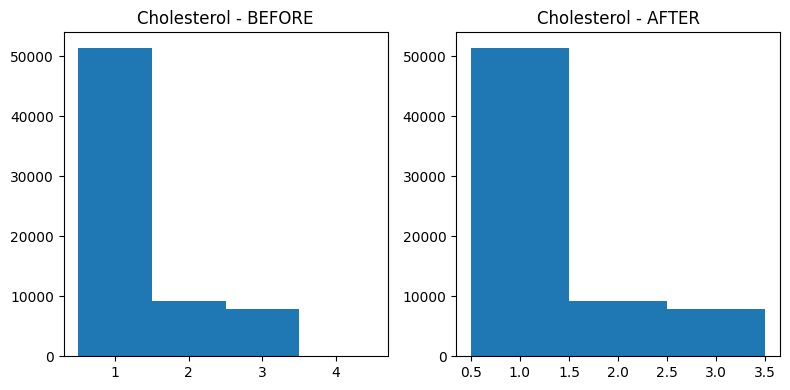

In [5]:
df_step3 = df.copy()

# Count invalids BEFORE
print("Invalid values before filtering:")
print("gender:", (~df_step3['gender'].isin([1, 2])).sum())
print("cholesterol:", (~df_step3['cholesterol'].isin([1, 2, 3])).sum())
print("gluc:", (~df_step3['gluc'].isin([1, 2, 3])).sum())
for col in ['smoke', 'alco', 'active', 'cardio']:
    print(f"{col}:", (~df_step3[col].isin([0, 1])).sum())

# Apply filters
df = df[df['gender'].isin([1, 2])]
df = df[df['cholesterol'].isin([1, 2, 3])]
df = df[df['gluc'].isin([1, 2, 3])]
for col in ['smoke', 'alco', 'active', 'cardio']:
    df = df[df[col].isin([0, 1])]

print("Rows removed in Step 4:", df_step3.shape[0] - df.shape[0])

# Example plot: Cholesterol distribution before/after
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].hist(df_step3['cholesterol'], bins=[0.5,1.5,2.5,3.5,4.5])
axes[0].set_title("Cholesterol - BEFORE")
axes[1].hist(df['cholesterol'], bins=[0.5,1.5,2.5,3.5])
axes[1].set_title("Cholesterol - AFTER")
plt.tight_layout()
plt.show()


# Step 5 – Post-Cleaning Sanity Checks

Now that we’ve removed corrupted entries and standardized categories,  
we need to verify that our dataset integrity and balance are preserved.

We’ll:
1. Confirm class balance (cardio 0/1)
2. Re-examine correlations of continuous variables with `cardio`
3. Compare BMI distributions before and after cleaning

Final dataset shape: (68562, 14)
Class balance (cardio):
cardio
0    0.504901
1    0.495099
Name: proportion, dtype: float64
cardio       1.000000
ap_hi        0.428108
ap_lo        0.339713
pp           0.337047
age_years    0.239501
BMI          0.192906
weight       0.180849
height      -0.012744
Name: cardio, dtype: float64


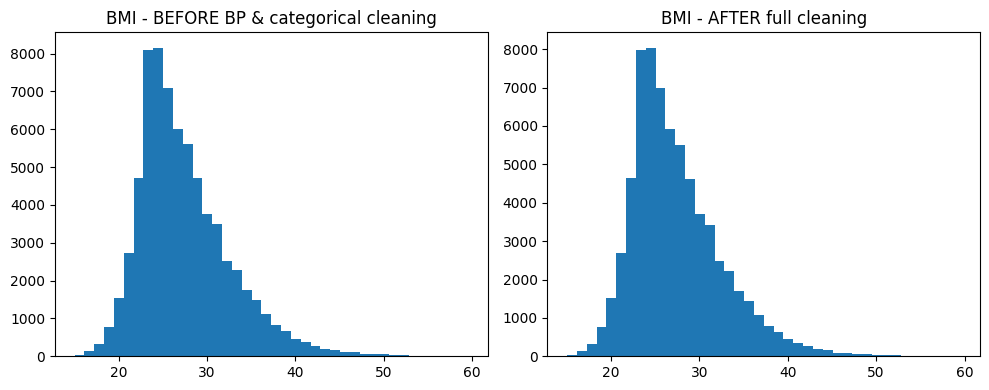

In [6]:
print("Final dataset shape:", df.shape)
print("Class balance (cardio):")
print(df['cardio'].value_counts(normalize=True))

num_cols = ['age_years', 'height', 'weight', 'BMI', 'ap_hi', 'ap_lo', 'pp']
corrs = df[num_cols + ['cardio']].corr()['cardio'].sort_values(ascending=False)
print(corrs)

# Compare BMI before and after full cleaning
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df_step2['BMI'], bins=40)
axes[0].set_title("BMI - BEFORE BP & categorical cleaning")
axes[1].hist(df['BMI'], bins=40)
axes[1].set_title("BMI - AFTER full cleaning")
plt.tight_layout()
plt.show()


# New Correlation Matrix

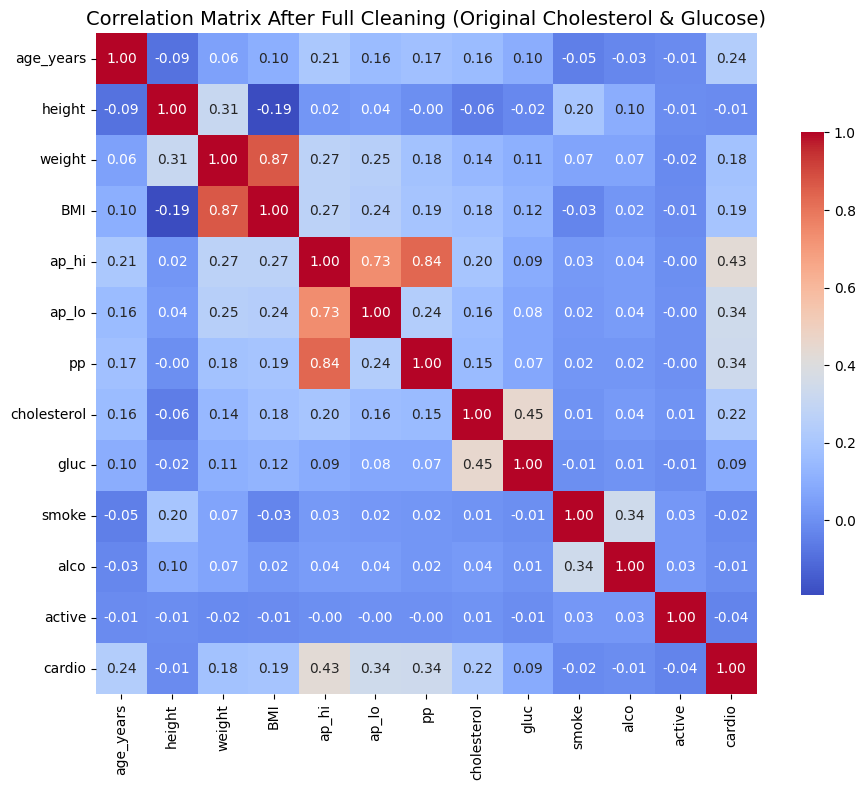


Top correlations with cardio:

cardio         1.000000
ap_hi          0.428108
ap_lo          0.339713
pp             0.337047
age_years      0.239501
cholesterol    0.221379
BMI            0.192906
weight         0.180849
gluc           0.089636
alco          -0.007832
height        -0.012744
smoke         -0.016150
active        -0.037665
Name: cardio, dtype: float64


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant features 
corr_features = [
    'age_years', 'height', 'weight', 'BMI',
    'ap_hi', 'ap_lo', 'pp',
    'cholesterol', 'gluc',
    'smoke', 'alco', 'active', 'cardio'
]

# Compute correlation matrix
corr_matrix = df[corr_features].corr()

# Plot correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.7}
)
plt.title("Correlation Matrix After Full Cleaning (Original Cholesterol & Glucose)", fontsize=14)
plt.tight_layout()
plt.show()

# Print top correlations with cardio
print("\nTop correlations with cardio:\n")
print(corr_matrix['cardio'].sort_values(ascending=False))
